In [1]:
import pandas as pd
from jsonlines import jsonlines
from tqdm import tqdm
import numpy as np
import pyspark
from pyspark import SparkContext
import json

In [2]:
sc = SparkContext()

23/11/16 17:22:42 WARN Utils: Your hostname, sebastien-Inspiron-7391-2n1 resolves to a loopback address: 127.0.1.1; using 192.168.1.73 instead (on interface wlp0s20f3)
23/11/16 17:22:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 17:22:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load the data

In [3]:
channel_data = pd.read_csv('data/df_channels_en.tsv', sep='\t')
print(channel_data['category_cc'].unique())

category = 'Gaming'
channel_data = channel_data[channel_data['category_cc'] == category]

['Gaming' 'Education' 'Entertainment' 'Howto & Style' 'Sports' 'Music'
 'Film and Animation' 'Comedy' 'Nonprofits & Activism' 'People & Blogs'
 'News & Politics' 'Science & Technology' 'Pets & Animals'
 'Autos & Vehicles' 'Travel & Events' nan]


In [4]:
# video_data = pd.read_json('data/climate_videos_new.jsonl', lines=True)

path_to_disk = '/Volumes/Maxtor'
path_to_disk_ubuntu = '/media/sebastien/Maxtor'
file_path = '/yt_metadata_en.jsonl'

# pyspark_df = pyspark.pandas.read_json(path_to_disk_ubuntu + file_path)
raw_data = sc.textFile(path_to_disk_ubuntu + file_path)
video_data = raw_data.map(lambda x: json.loads(x))
# video_data = sc.parallelize(raw_data.take(100000)).map(lambda x: json.loads(x))
video_data = video_data.filter(lambda x: x['categories'] == category)

# Look at channel matches in video title and description

In [5]:
channel_names = set(channel_data['name_cc'].dropna().unique().tolist())
print('Number of channels:', len(channel_names))
# print('Number of videos:', video_data.count())

# Search for presence of channel names in video title and description
def find_match(title: str, description: str, tags: str, channel_id: str):
    inter = channel_names.intersection(set(tags.split(',')))
    if len(inter) > 0:
        return list(inter)[0], channel_id
    else:
        return None
    
    # for channel_name in channel_names:
    #     if channel_name in tags:
    #         return title, channel_name
                
data = video_data.map(lambda x: find_match(x['title'], x['description'], x['tags'], x['channel_id']))
data = data.filter(lambda x: x is not None)
data = data.groupBy(lambda x: x[0]).map(lambda x: (x[0], len(x[1]), list([y[1] for y in x[1]])))
res = list(sorted(data.collect(), key=lambda item: item[1], reverse=True))

# Save as json file
with jsonlines.open('data/channel_matches_names.jsonl', 'w') as f:
    f.write_all(res)

Number of channels: 20082


# Load the graph data

In [297]:
import networkx as nx
import matplotlib.pyplot as plt
graph_data = pd.read_json('data/channel_matches_names.jsonl', lines=True)
graph_data.columns = ['channel_name', 'count', 'channel_ids']
graph_data = graph_data[graph_data['count'] > 1]
graph_data = graph_data[graph_data['count'] < 30]
# graph_data = graph_data[graph_data['channel_name'].apply(lambda x: len(x) > 10)]
display(graph_data)

,channel_name,count,channel_ids
5555,Magdumper,29,"[UC8GgWNnnkTX2hoIYcPqzqLw, UC8GgWNnnkTX2hoIYcP..."
5556,Kid Buu Productions,29,"[UCXUN8TXHSsi0bTYPpEpR-7w, UCXUN8TXHSsi0bTYPpE..."
5557,Lemons,29,"[UCpf42a3Bz4M9AdRDBXukneQ, UCo2VRBas3X8OFc6SzA..."
5558,Micky,29,"[UCqGAbWI6MhUb4rmXEVQM2CA, UCmrsjRoN3g5TtOGIlq..."
5559,FishPC,29,"[UCnw1YCM2QvttBzOHGTuQlyg, UCnw1YCM2QvttBzOHGT..."
...,...,...,...
10386,GoldVision,2,"[UCcgIn0w6Bs9vW4qYZSaHHNA, UCvBv3PCvD9v-IKKTkd..."
10387,Jhostyn Sanchez,2,"[UCBxcQu1U7UUYOgxFhkHGZGQ, UCBxcQu1U7UUYOgxFhk..."
10388,Plox,2,"[UCRAs1f91PRIKXVC_3S_3IdQ, UCI02LaMt-ald7yPdpO..."
10389,MetPro SOWC,2,"[UCfl2oad92BwBMsZV7ztVtkA, UC1PhTs67PPip_Ys0_x..."


# Convert channel ids to channel names in the graph data 

In [298]:
# graph_data = graph_data.sample(1000)
channel_id_to_name = {row['channel']: row['name_cc'] for _, row in channel_data.iterrows()}
graph_data['channel_names'] = graph_data['channel_ids'].apply(lambda x: [channel_id_to_name[y] for y in x if y in channel_id_to_name])
display(graph_data['channel_names'])

5555     [Magdumper, Magdumper, Magdumper, Magdumper, M...
5556     [Kid Buu Productions, Kid Buu Productions, Kid...
5557     [ToshDeluxe, Meta, Meta, Meta, TheFaitKO, Bran...
5558     [TheRoyalGorilla, XboxViewTV, XboxViewTV, Mick...
5559     [VIRTUAL FIFA, VIRTUAL FIFA, VIRTUAL FIFA, VIR...
                               ...                        
10386                           [Speer Gaming, GoldVision]
10387                   [Jhostyn Sanchez, Jhostyn Sanchez]
10388                       [TrainerChip, Thereaper123666]
10389                          [UVersusPro, GhillieMaster]
10390                             [NourElDinx, NourElDinx]
Name: channel_names, Length: 4836, dtype: object

# Construct the graph nodes and edegs 

In [299]:
from collections import Counter
graph_data['channel_names'] = graph_data['channel_names'].apply(lambda x: dict(Counter(x)))

In [309]:
nodes = graph_data['channel_name'].tolist()
edges = []
for i, row in graph_data.iterrows():
    edge_batch = [(row['channel_name'], channel_name, {'weight': count}) for channel_name, count in row['channel_names'].items()]
    edges.extend(edge_batch)
    
print(len(nodes), '\n', nodes[:10])
print(len(edges), '\n',edges[:10])

4836 
 ['Magdumper', 'Kid Buu Productions', 'Lemons', 'Micky', 'FishPC', 'Rare Candy', 'Xiomaro', 'GenerationHollow', 'CPWorld', 'EDM Plus']
10530 
 [('Magdumper', 'Magdumper', {'weight': 29}), ('Kid Buu Productions', 'Kid Buu Productions', {'weight': 29}), ('Lemons', 'ToshDeluxe', {'weight': 1}), ('Lemons', 'Meta', {'weight': 3}), ('Lemons', 'TheFaitKO', {'weight': 1}), ('Lemons', 'Brandon Larkin', {'weight': 1}), ('Lemons', 'Bunny Films', {'weight': 1}), ('Lemons', 'AZNpoke', {'weight': 1}), ('Lemons', 'Golden', {'weight': 1}), ('Lemons', 'Vishera Games', {'weight': 1})]


In [301]:
# Filter edges that map to themselves and edges that are not in the nodes
edges = [edge for edge in edges if edge[0] != edge[1]]
edges = [edge for edge in edges if edge[1] in nodes]
print(len(edges), edges[:10])

1861 [('Lemons', 'TheFaitKO', {'weight': 1}), ('Lemons', 'Brandon Larkin', {'weight': 1}), ('Lemons', 'AZNpoke', {'weight': 1}), ('Lemons', 'Badman Reviews', {'weight': 1}), ('Lemons', 'Noctalium', {'weight': 2}), ('Lemons', 'ProxarPlays', {'weight': 1}), ('Lemons', 'TheLoneFew', {'weight': 1}), ('Micky', 'Professor Broman', {'weight': 16}), ('Rare Candy', 'MrGamingZone', {'weight': 3}), ('Rare Candy', 'Poké AK', {'weight': 2})]


# Construct the graph

In [302]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
# Calculate the degree (number of neighbors) for 
nodes_degree_0 = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(nodes_degree_0)

In [303]:
# Save the graph
nx.write_graphml(G, 'data/graph.graphml')
# Load the graph
G = nx.read_graphml('data/graph.graphml')
print(G)

Graph with 2153 nodes and 1833 edges


In [314]:
import community
partition = community.best_partition(G)
print(len(partition))

2153


['JohnnyBoi_i', 'ProDaNTe', 'ZiggyD Gaming', 'TheFlightChannel', 'Aus Flight Simmer', 'TouchGameplay', 'Elgin', 'iifnatik', 'DaphneElaine']


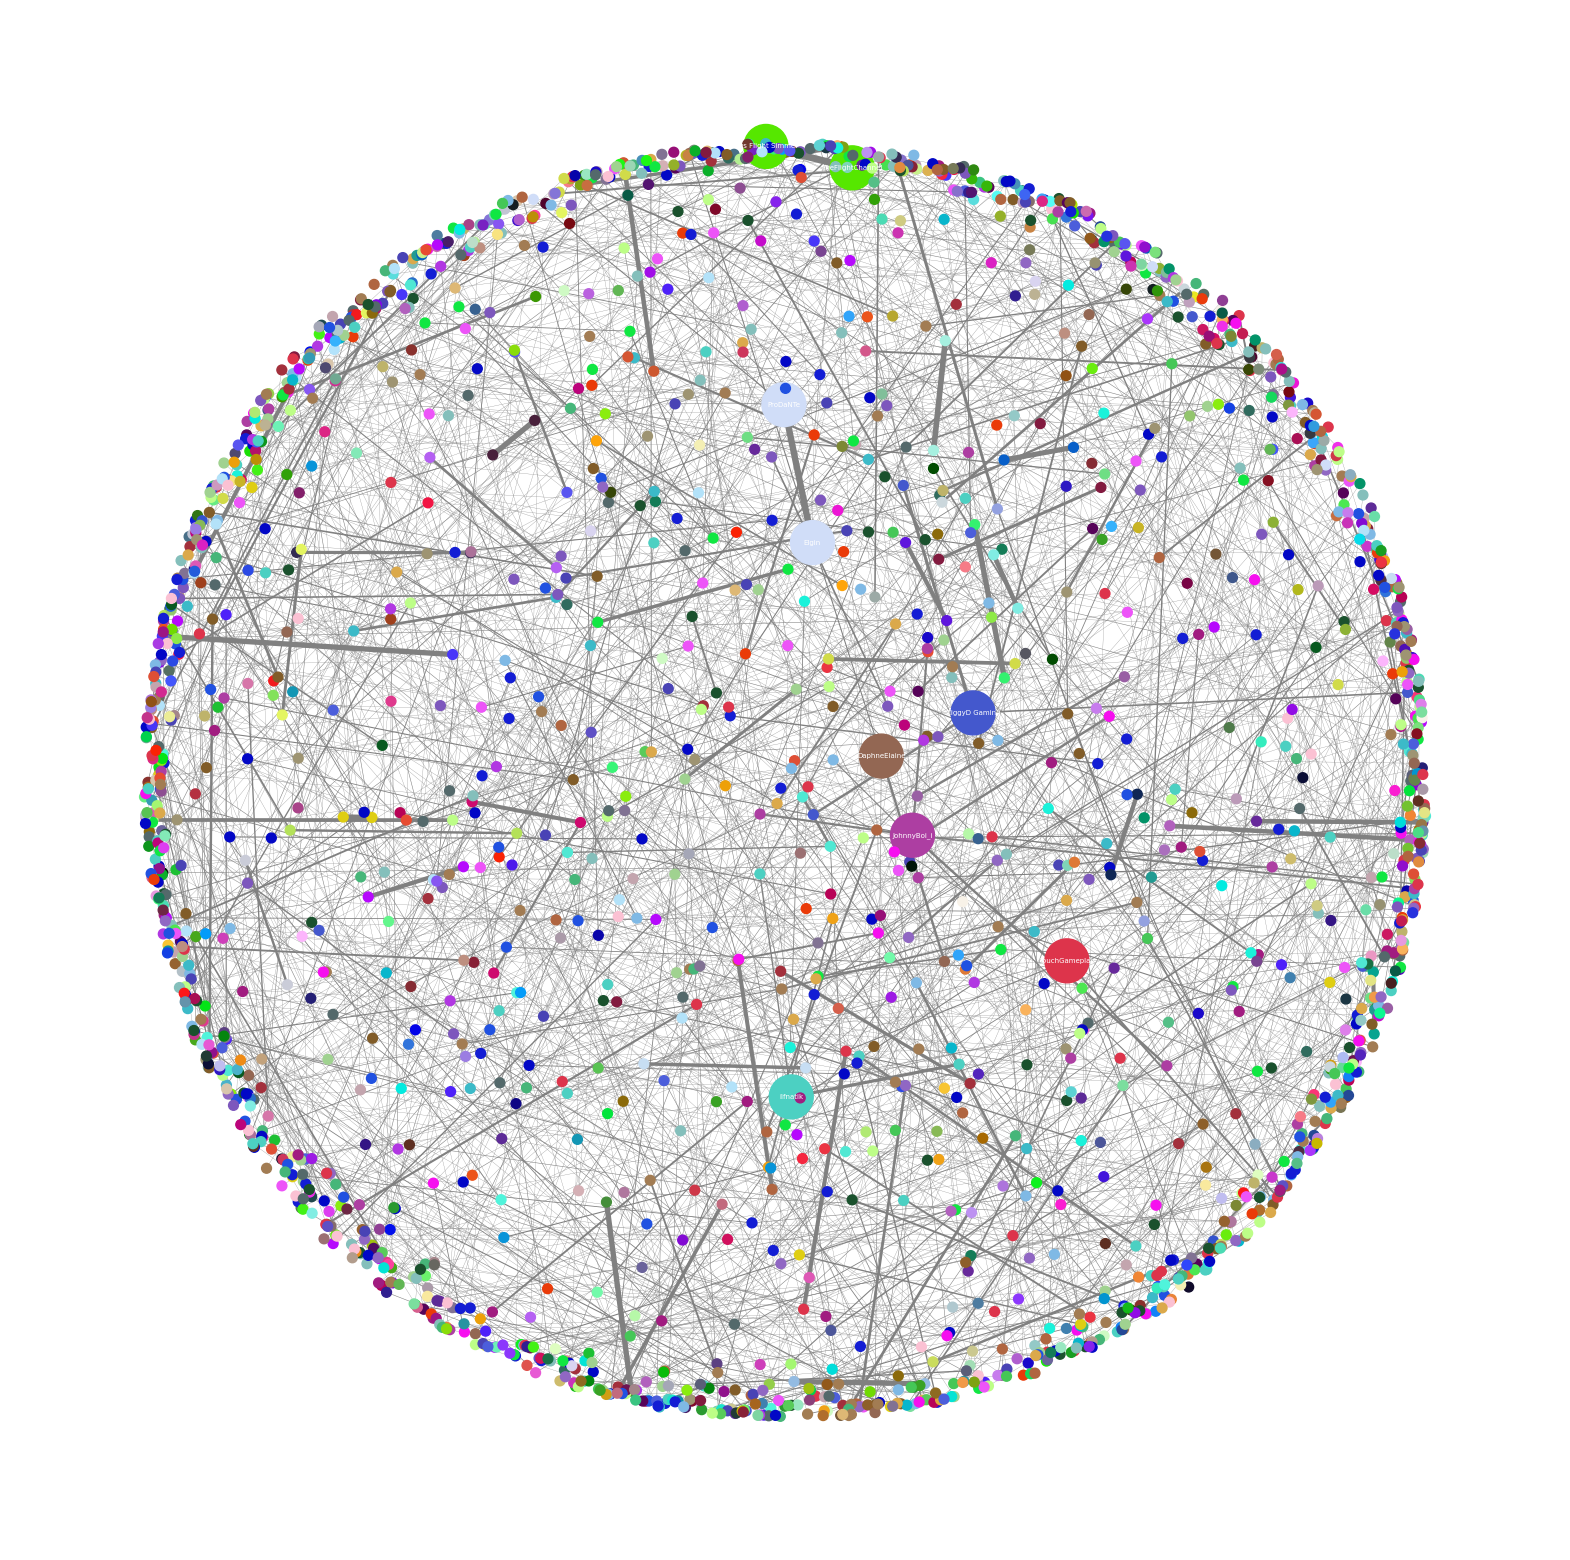

Most connected channels: {'JohnnyBoi_i': 'JohnnyBoi_i', 'ProDaNTe': 'ProDaNTe', 'ZiggyD Gaming': 'ZiggyD Gaming', 'TheFlightChannel': 'TheFlightChannel', 'Aus Flight Simmer': 'Aus Flight Simmer', 'TouchGameplay': 'TouchGameplay', 'Elgin': 'Elgin', 'iifnatik': 'iifnatik', 'DaphneElaine': 'DaphneElaine'}


In [317]:
pos = nx.spring_layout(G, k=1.5, iterations=200)

top_nodes = list(map(lambda x: x[0], sorted(G.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:len(nodes) // 500]))
print(top_nodes)


# Draw nodes and edges
import random
colors = {community_id: "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
          for community_id in set(partition.values())}

# Extract node colors based on community membership
node_color = [colors[partition[node]] for node in G.nodes()]

# Highlight the top nodes by changing their color or size
# node_color = ['red' if node in top_nodes else 'blue' for node in G.nodes()]
node_size = [1000 if node in top_nodes else 50 for node in G.nodes()]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_weights = [weight / max(edge_weights) * 5 for weight in edge_weights]

fig, ax = plt.subplots(figsize=(20, 20))
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=node_size, node_color=node_color, font_color='black', edge_color='gray', width=edge_weights, ax=ax)

# Show node labels for the top nodes
labels = {node: str(node) for node in top_nodes}
nx.draw_networkx_labels(G, pos, labels, font_color='white', font_size=5)

# Show the plot
plt.show()

print(f"Most connected channels: {labels}")